# Extrae los archivos descargados y genera los tidy

In [11]:
# Importando las librerías...

# Manejar rutas
from pathlib import Path

# Cargar y transformar datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import plotly.graph_objects as go

%matplotlib widget
%matplotlib inline

# Manejo de valores faltantes
import missingno as msno

In [12]:
# Establecer las rutas para acceder a nuestros datos...

data_path = Path('./data')
data_path.mkdir(parents=True, exist_ok=True)

# Crear carpeta de datos Tidy...
tidy_data_path = Path(data_path / 'tidy')
tidy_data_path.mkdir(parents=True, exist_ok=True)

In [13]:
print(data_path)

data


# 1. Proyecciones de población de la CONAPO
Se carga el CSV de proyección de poblacion desde el año 1950 hasta el 2070.  
Puede tardar un poco ya que es un archivo con más de 744 mil registros

In [14]:
df_proyecciones = pd.read_excel(data_path / "0_Pob_Inicio_1950_2070.xlsx")

In [15]:
df_proyecciones.describe()

,RENGLON,AÑO,CVE_GEO,EDAD,POBLACION
count,744920.0000,744920.000000,744920.000000,744920.000000,7.449200e+05
mean,372460.5000,2020.139693,15.905493,54.500000,3.289038e+04
std,215040.0256,29.729490,9.572587,31.752974,1.160257e+05
min,1.0000,1950.000000,0.000000,0.000000,0.000000e+00
25%,186230.7500,1995.000000,8.000000,27.000000,2.017000e+03
50%,372460.5000,2020.000000,16.000000,54.500000,1.018200e+04
75%,558690.2500,2046.000000,24.000000,82.000000,2.435625e+04
max,744920.0000,2071.000000,32.000000,109.000000,1.260813e+06


In [16]:
df_proyecciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744920 entries, 0 to 744919
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   RENGLON    744920 non-null  int64 
 1   AÑO        744920 non-null  int64 
 2   ENTIDAD    744920 non-null  object
 3   CVE_GEO    744920 non-null  int64 
 4   EDAD       744920 non-null  int64 
 5   SEXO       744920 non-null  object
 6   POBLACION  744920 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 39.8+ MB


In [17]:
df_proyecciones = df_proyecciones.drop("RENGLON", axis = 1)
df_proyecciones

,AÑO,ENTIDAD,CVE_GEO,EDAD,SEXO,POBLACION
0,1950,República Mexicana,0,0,Hombres,577250
1,1950,República Mexicana,0,0,Mujeres,564734
2,1950,República Mexicana,0,1,Hombres,520692
3,1950,República Mexicana,0,1,Mujeres,511958
4,1950,República Mexicana,0,2,Hombres,487298
...,...,...,...,...,...,...
744915,2071,Zacatecas,32,107,Mujeres,44
744916,2071,Zacatecas,32,108,Hombres,75
744917,2071,Zacatecas,32,108,Mujeres,26
744918,2071,Zacatecas,32,109,Hombres,50


### Diccionario de datos de proyección de población
<div align="center">

|  variable |  tipo de dato |  descripción | valores nulos |
|-----------|---------------|--------------|--------------|
| AÑO       | int           | Año referente a la población    | Ninguno |
| ENTIDAD   | str           | Nombre del estado    | Ninguno |
| CVE_GEO   | int           | Clave del estado por defecto    |Ninguno |
| SEXO      | str           | sexo en hombre o mujer    |Ninguno |
| EDAD      | int           | edad de la población   |Ninguno |
| POBLACION | int           | poblacion total de personas que cumplen las variables anteriores   |Ninguno |

In [18]:
# Consultar la población de de todos los años desde el 2016 al 2023...
pob_anhos = (df_proyecciones.loc[(df_proyecciones["AÑO"] >= 2015) &
                                (df_proyecciones["AÑO"] <= 2023), ["AÑO","CVE_GEO","POBLACION"]]
                                .groupby(["AÑO","CVE_GEO"]).sum())
print("Del 2015 al 2023 - Todas las Unidades Federeativas...")
pob_anhos

Del 2015 al 2023 - Todas las Unidades Federeativas...


POBLACION
AÑO  CVE_GEO           
2015 0        121734816
     1          1332990
     2          3366781
     3           722099
     4           913091
...                 ...
2023 28         3669309
     29         1404030
     30         8132954
     31         2436635
     32         1675298

[297 rows x 1 columns]

In [19]:
# Para EDA, evaluar luego pirámide poblacional...
grupos_etarios = {1: '0 a 4',
                  2: '5 a 9',
                  3: '10 a 14',
                  4: '15 a 19',
                  5: '20 a 24',
                  6: '25 a 29',
                  7: '30 a 34',
                  8: '35 a 39',
                  9: '40 a 44',
                  10: '45 a 49',
                  11: '50 a 54',
                  12: '55 a 59',
                  13: '60 a 64',
                  14: '65 a 69',
                  15: '70 a 74',
                  16: '75 a 79',
                  17: '80 a 84',
                  18: '85 y más',
                  }

In [20]:
# Creamos una copia de proyecciones donde se trabajará con Grupos etarios... Para Pirámides poblacionales...
df_piramides = df_proyecciones.copy()

# Agregamos la Columna para almacenar el Grupo etario...
df_piramides["GRUPO"] = 0

# Reordenamos las columnas...
df_piramides = df_piramides[["AÑO", "ENTIDAD", "CVE_GEO", "EDAD", "GRUPO", "SEXO", "POBLACION"]]

In [21]:
# Dando los valores a los grupos etarios...
edad_cero = df_piramides["EDAD"] == 0
edad_mayor85 = df_piramides["EDAD"] >= 85

df_piramides.loc[edad_cero, "GRUPO"] = 1
df_piramides.loc[~edad_cero,  "GRUPO"] = df_piramides["EDAD"] // 5 + 1
df_piramides.loc[edad_mayor85,  "GRUPO"] = 18

# Cambiando los valores por etiquetas para graficar...
df_piramides["GRUPO"] = df_piramides["GRUPO"].map(grupos_etarios)

# Limitamos a las poblaciones desde el 2015 al 2023...
pop_2015_2023 = (df_piramides["AÑO"] >= 2015) & (df_piramides["AÑO"] <= 2023)
df_piramides = df_piramides[pop_2015_2023]

df_piramides

,AÑO,ENTIDAD,CVE_GEO,EDAD,GRUPO,SEXO,POBLACION
331100,2015,República Mexicana,0,0,0 a 4,Hombres,1134441
331101,2015,República Mexicana,0,0,0 a 4,Mujeres,1093705
331102,2015,República Mexicana,0,1,0 a 4,Hombres,1138096
331103,2015,República Mexicana,0,1,0 a 4,Mujeres,1097638
331104,2015,República Mexicana,0,2,0 a 4,Hombres,1145745
...,...,...,...,...,...,...,...
396435,2023,Zacatecas,32,107,85 y más,Mujeres,2
396436,2023,Zacatecas,32,108,85 y más,Hombres,2
396437,2023,Zacatecas,32,108,85 y más,Mujeres,0
396438,2023,Zacatecas,32,109,85 y más,Hombres,1


In [22]:
# Crear el Archivo tidy para trabajar...
df_piramides.to_csv(tidy_data_path / "proyecciones_conapo.csv", index=False)

In [23]:
# Ejemplo de como filtrar por población y entidad federativa...
# df_piramides = pd.read_csv(tidy_data_path / "proyecciones_conapo.csv")
df_pob_graf = (df_piramides.loc[(df_piramides["AÑO"] == 2023) & (df_piramides["ENTIDAD"] == "República Mexicana"), ["GRUPO", "SEXO", "POBLACION"]].groupby(["GRUPO", "SEXO"]).sum())
df_pob_graf

POBLACION
GRUPO    SEXO              
0 a 4    Hombres    5302794
         Mujeres    5111446
10 a 14  Hombres    5755183
         Mujeres    5548855
15 a 19  Hombres    5699745
         Mujeres    5565159
20 a 24  Hombres    5656809
         Mujeres    5589713
25 a 29  Hombres    5456502
         Mujeres    5462331
30 a 34  Hombres    5128604
         Mujeres    5269345
35 a 39  Hombres    4461141
         Mujeres    4853878
40 a 44  Hombres    3794214
         Mujeres    4452137
45 a 49  Hombres    3639280
         Mujeres    4239229
5 a 9    Hombres    5480803
         Mujeres    5281378
50 a 54  Hombres    3382531
         Mujeres    3801484
55 a 59  Hombres    2910303
         Mujeres    3222708
60 a 64  Hombres    2341387
         Mujeres    2611480
65 a 69  Hombres    1741021
         Mujeres    1980902
70 a 74  Hombres    1225427
         Mujeres    1425582
75 a 79  Hombres     869740
         Mujeres    1037149
80 a 84  Hombres     541763
         Mujeres     668625
85 y más Hombres     461925
         Mujeres     585083

In [24]:
# Graficando la pirámide poblacional...
def graficar_piramide(filtro_anio): # , filtro_entidad

    df_pob_graf = (df_piramides.loc[(df_piramides["AÑO"] == filtro_anio) & (df_piramides["ENTIDAD"] == "República Mexicana"), ["GRUPO", "SEXO", "POBLACION"]].groupby(["GRUPO", "SEXO"]).sum())

    
    edad = list(grupos_etarios.values())
    hombres = [df_pob_graf["POBLACION"][grupos]["Hombres"] for grupos in grupos_etarios.values()]
    mujeres = [df_pob_graf["POBLACION"][grupos]["Mujeres"] for grupos in grupos_etarios.values()]

    # Crear la figura
    fig = go.Figure()

    # Barras para hombres
    fig.add_trace(go.Bar(
        y=edad,
        x=hombres,
        orientation='h',
        name='Hombres',
        marker=dict(color='blue'),
    ))

    # Barras para mujeres con valores negativos para invertir el eje y
    fig.add_trace(go.Bar(
        y=edad,
        x=[-x for x in mujeres],
        orientation='h',
        name='Mujeres',
        marker=dict(color='pink'),
    ))

    # Personalizar diseño y diseño de la figura
    fig.update_layout(
        title= f'Pirámide Poblacional de México. Año {filtro_anio}.',
        barmode='overlay',
        bargap=0.1,
        #paper_bgcolor='white',
        plot_bgcolor='white',  # Sin fondo

        xaxis=dict(
            tickmode='array',
            title="Cantidad de personas (Millones)",
            tickvals=[-6000000, -4000000, -2000000, 0,2000000,4000000,6000000],
            ticktext=["6M", "4M","2M", "0", "2M", "4M","6M"],
            showgrid=False,
        ),

        yaxis=dict(
            tickmode='array',
            tickvals=list(range(len(edad))),
            ticktext=edad,
            showgrid=False,
        ),
        width=800,  # Ancho de la figura
        height=600,  # Altura de la figura
    )

    # Mostrar la figura
    fig.show()
    
# Luego hacerlo por entidades también... filtro_entidad = df_piramides["ENTIDAD"].unique()
widgets.interact(graficar_piramide, filtro_anio = df_piramides["AÑO"].unique())

interactive(children=(Dropdown(description='filtro_anio', options=(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2…

<function __main__.graficar_piramide(filtro_anio)>

### Población de un año por entidades

In [25]:
# Consultar la población de un Año y Entidad específica...

def pob_por_anhos(anho,entidad):
    return pob_anhos["POBLACION"][anho][entidad]

print(f"Año 2023, Sonora: {pob_por_anhos(2023,26):,}")
print(f"Año 2022, Todo México: {pob_por_anhos(2022,0):,}")

Año 2023, Sonora: 3,066,575
Año 2022, Todo México: 129,365,552


Se puede ver que la población estimada en el 2022 fue de 128 600 339...

Resultado anteriormente visto:

En el año 2022 ocurrieron 17 445 homicidios. Para una tasa de 13.8 calculada con la población de México del 2010.

$Tasa = \frac{17 445}{126 014 024} * 100 000 = 13.8$

Recalculando con la población estimada para el 2022 por la CONAPO:

$Tasa = \frac{17 445}{129 365 552} * 100 000 = 13.5$

Según [CONAPO](https://www.inegi.org.mx/contenidos/saladeprensa/aproposito/2023/EAP_DMPO23.pdf) ya en 2023 existen unos 129 Millones de habitantes en México, y cada vez sería mayor la precisión si se asume también que estas las estimaciones son precisas.

En el ejemplo anterior, que es una diferencia de 0.3? Si se invierten los cálculos esta diferencia estaría entre 378 y 388 homicidios.

Sin embargo. Valdrá la pena usar estimaciones de población para calcular las tasas específicas??? Vamos a intentar chequear esto durante el proyecto.

# 2. Encuesta de percepción de inseguridad pública (INEGI)

Los datos que necesitamos se encuentran en distintos documentos de excel, así que primero descargaremos todos y despues juntaremos los datos en un solo DataFrame.

In [26]:
"""
# Manejar rutas
from pathlib import Path

# Cargar y transformar datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
"""

'\n# Manejar rutas\nfrom pathlib import Path\n\n# Cargar y transformar datos\nimport pandas as pd\nimport numpy as np\n\n# Visualización\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n'

Establecer las rutas para acceder a nuestros datos

In [27]:
# data_path = Path('./data')
percepcion_path = data_path / 'percepcion'

In [28]:
dfs_percepcion = {}

#Leemos datos año por año ya que los parametros para lectura cambia
dfs_percepcion[2011] = pd.read_excel(percepcion_path / 'percepcion_2011.xlsx', sheet_name= 1, skiprows = 9, usecols = [0,4], names = ['Entidad', '2011'], nrows=33)
dfs_percepcion[2012] = pd.read_excel(percepcion_path / 'percepcion_2012.xlsx', sheet_name = 4, skiprows = 9, usecols = [0,7], names = ['Entidad', '2012'], nrows=33)
dfs_percepcion[2013] = pd.read_excel(percepcion_path / 'percepcion_2013.xlsx', sheet_name = 4, skiprows = 9, usecols = [0,7], names = ['Entidad', '2013'], nrows=33)
dfs_percepcion[2014] = pd.read_excel(percepcion_path / 'percepcion_2014.xlsx', sheet_name = 4, skiprows = 9, usecols = [0,7], names = ['Entidad', '2014'], nrows=33)
dfs_percepcion[2015] = pd.read_excel(percepcion_path / 'percepcion_2015.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2015'], nrows=33)
dfs_percepcion[2016] = pd.read_excel(percepcion_path / 'percepcion_2016.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2016'], nrows=33)
dfs_percepcion[2017] = pd.read_excel(percepcion_path / 'percepcion_2016.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2017'], nrows=33)
dfs_percepcion[2018] = pd.read_excel(percepcion_path / 'percepcion_2018.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2018'], nrows=33)
dfs_percepcion[2019] = pd.read_excel(percepcion_path / 'percepcion_2019.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2019'], nrows=33)
dfs_percepcion[2020] = pd.read_excel(percepcion_path / 'percepcion_2020.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2020'], nrows=33)
dfs_percepcion[2021] = pd.read_excel(percepcion_path / 'percepcion_2021.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2021'], nrows=33)
dfs_percepcion[2022] = pd.read_excel(percepcion_path / 'percepcion_2022.xlsx', sheet_name = 10, skiprows = 9, usecols = [0,7], names = ['Entidad', '2022'], nrows=33)
dfs_percepcion[2023] = pd.read_excel(percepcion_path / 'percepcion_2023.xlsx', sheet_name = 13, skiprows = 9, usecols = [0,7], names = ['Entidad', '2023'], nrows=33)

#creamos Dataframe
for año in range(2011, 2023):
  if año == 2011:
    entidades_percep = pd.merge(dfs_percepcion[año], dfs_percepcion[año + 1][str(año+1)], left_index=True, right_index=True)
  else:
    entidades_percep = pd.merge(entidades_percep, dfs_percepcion[año + 1][str(año+1)], left_index=True, right_index=True)

entidades_percep

,Entidad,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Estados Unidos Mexicanos,69.536343,66.622674,72.322457,73.254528,73.208739,72.350354,72.350354,79.390885,78.923315,78.575746,75.638192,75.913019,74.629466
1,Aguascalientes,60.781293,46.521325,51.807434,49.104040,43.178322,42.452607,42.452607,60.889151,56.380828,54.587324,51.545596,54.215804,49.658546
2,Baja California,58.225411,51.571792,51.487931,53.690572,53.240621,56.808145,56.808145,72.656270,66.435304,64.213874,68.070188,76.148656,68.498969
3,Baja California Sur,37.118676,24.444105,30.110138,39.260519,61.824967,44.196116,44.196116,65.287080,48.206110,35.701805,34.319915,34.911697,33.371377
4,Campeche,51.248149,44.635927,56.709175,58.924918,53.672307,54.371741,54.371741,57.849665,61.028125,56.100644,53.218513,54.092616,61.602961
5,Coahuila de Zaragoza,64.577258,74.636522,81.985641,78.495093,74.920929,55.887501,55.887501,64.044869,57.086843,53.034331,53.367409,50.351069,44.132750
6,Colima,65.825673,70.792383,71.130544,56.871114,56.535474,72.023937,72.023937,80.496832,77.829184,73.329385,72.480947,85.756391,80.909954
7,Chiapas,38.273959,37.855227,50.956874,62.091154,54.618653,57.248306,57.248306,71.365532,68.752408,66.960754,66.652183,72.600297,68.074699
8,Chihuahua,89.531810,82.713819,78.048216,75.167071,73.602332,63.110443,63.110443,80.851955,80.843337,75.671868,73.582572,71.558237,78.112335
9,Distrito Federal,75.257200,70.793563,73.006600,77.608380,78.475619,84.623704,84.623704,88.316683,89.226879,85.778970,85.273931,83.228952,80.099689


In [29]:
# Crear el Archivo tidy para trabajar...
entidades_percep.to_csv(tidy_data_path / "percepcion_inseguridad_inegi.csv", index=False)

# 3. Incidencia delictiva

In [30]:
print(data_path)

data


In [31]:
delitos_path = data_path / "data_delitos.csv"

Cargamos el dataframe y cambiamos los nombres de las columnas

In [32]:
df_delitos = pd.read_csv(delitos_path, encoding = 'iso-8859-1')
df_delitos.rename(
    columns={
        "Año" : "anio",
        "Clave_Ent" : "clave_ent",
        "Entidad" : "entidad",
        "Cve. Municipio" : "clave_municipio",
        "Municipio" : "municipio",
        "Bien jurídico afectado": "bien_afectado",
        "Tipo de delito" : "tipo_delito",
        "Subtipo de delito" : "subtipo_delito",
        "Modalidad" : "modalidad",
        "Enero" : "enero",
        "Febrero" : "Febrero",
        "Marzo" : "marzo",
        "Abril" : "abril",
        "Mayo" : "mayo",
        "Junio" : "junio",
        "Julio" : "julio",
        "Agosto" : "agosto",
        "Septiembre" : "septiembre",
        "Octubre" : "octubre",
        "Noviembre" : "noviembre",
        "Diciembre" : "diciembre",
    },
    inplace = True
)

In [33]:
df_delitos

,anio,clave_ent,entidad,clave_municipio,municipio,bien_afectado,tipo_delito,subtipo_delito,modalidad,enero,...,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0,1,1,0,2,1.0,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0,1,0,1,0,0.0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3,2,0,1,2,0.0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0,0,0,0,0,0.0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075733,2023,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Falsificación,Falsificación,Falsificación,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2075734,2023,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Contra el medio ambiente,Contra el medio ambiente,Contra el medio ambiente,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2075735,2023,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,Delitos cometidos por servidores públicos,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2075736,2023,32,Zacatecas,32058,Santa María de la Paz,Otros bienes jurídicos afectados (del fuero co...,Electorales,Electorales,Electorales,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


### Diccionario delitos


<div align="center">

|  variable |  tipo de dato |  descripción | valores nulos |
|-----------|---------------|--------------|--------------|
| anio       | int           |  Año de la instancia   |  0
|clave_ent | int             | Número que representa el estado en el orden usual| 0|
| entidad   |  str         | Nombre del estado| 0|
|clave_municipio| int | Clave númerica del municipio| 0|
| municipio | str | Nombre del municipio | 0|
| bien_afectado| str | se refiere a la propiedad o los activos que han sido dañados, robados,<br />destruidos o de alguna manera perjudicados como resultado del delito | 0 |
|tipo_delito | str| se refiere a la categorización o clasificación de un delito en función de<br /> sus características y la naturaleza de la actividad ilegal.  | 0|
|subtipo_delito| str | Segundo nivel de clasificacion de delito | 0|
| modalidad | str | forma específica o a las circunstancias en las que se comete el delito | 0|
|enero | int | conteo de delitos durante enero | 0|
|febrero | int | conteo de delitos durante febrero | 0|
|marzo | int | conteo de delitos durante marzo | 0  |   
|abril | int | conteo de delitos durante abril | 0  |                           
|mayo | int | conteo de delitos durante mayo | 0  |  
|junio | int | conteo de delitos durante junio | 0  |   
|julio | int | conteo de delitos durante julio | 0  |  
|agosto | int | conteo de delitos durante agosto | 0  |  
|septiembre | float | conteo de delitos durante septiembre | 243,334  |  
|octubre | float | conteo de delitos durante octubre | 243,334  |  
|noviembre | float | conteo de delitos durante noviembre | 243,334  |  
|diciembre | float | conteo de delitos durante diciembre | 243,334  |         

In [34]:
# Ojo en este archivo no viene una suma total del país como entidad 0, igual que en el archivo anterior... esta habrá que crearla...
df_delitos["clave_ent"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [35]:
df_delitos.info()

df_delitos.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075738 entries, 0 to 2075737
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   anio             int64  
 1   clave_ent        int64  
 2   entidad          object 
 3   clave_municipio  int64  
 4   municipio        object 
 5   bien_afectado    object 
 6   tipo_delito      object 
 7   subtipo_delito   object 
 8   modalidad        object 
 9   enero            int64  
 10  Febrero          int64  
 11  marzo            int64  
 12  abril            int64  
 13  mayo             int64  
 14  junio            int64  
 15  julio            int64  
 16  agosto           int64  
 17  septiembre       int64  
 18  octubre          float64
 19  noviembre        float64
 20  diciembre        float64
dtypes: float64(3), int64(12), object(6)
memory usage: 332.6+ MB


(2075738, 21)

## Transformación de los datos
Al parecer los datos de proyección de población no necesitan procesamiento. Nos concentraremos entonces en los de incidencia delictiva.

## Manejo de datos faltantes

In [36]:
# Columnas con valores nulos...
df_delitos.isnull().sum()

anio                    0
clave_ent               0
entidad                 0
clave_municipio         0
municipio               0
bien_afectado           0
tipo_delito             0
subtipo_delito          0
modalidad               0
enero                   0
Febrero                 0
marzo                   0
abril                   0
mayo                    0
junio                   0
julio                   0
agosto                  0
septiembre              0
octubre            243334
noviembre          243334
diciembre          243334
dtype: int64

In [37]:
"""
%matplotlib inline
import missingno as msno
"""

'\n%matplotlib inline\nimport missingno as msno\n'

In [38]:
msno.matrix(df_delitos)

<Axes: >

Se puede ver que los valores faltantes estan en la ultima parte del dataset (fechas mas actuales) y en los ultimos meses. Esto quire decir que no hay datos capturados a partir de septiembre para 2023, lo cual es de lógico.

In [ ]:
# Esas columnas son de valores numéricos... se van a sustituir por ceros...
df_delitos.fillna(0, inplace=True)

df_delitos.isnull().sum()
# Resuelto...

anio               0
clave_ent          0
entidad            0
clave_municipio    0
municipio          0
bien_afectado      0
tipo_delito        0
subtipo_delito     0
modalidad          0
enero              0
Febrero            0
marzo              0
abril              0
mayo               0
junio              0
julio              0
agosto             0
septiembre         0
octubre            0
noviembre          0
diciembre          0
dtype: int64

## Manejo de tipo de datos

In [ ]:
df_delitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075738 entries, 0 to 2075737
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   anio             int64  
 1   clave_ent        int64  
 2   entidad          object 
 3   clave_municipio  int64  
 4   municipio        object 
 5   bien_afectado    object 
 6   tipo_delito      object 
 7   subtipo_delito   object 
 8   modalidad        object 
 9   enero            int64  
 10  Febrero          int64  
 11  marzo            int64  
 12  abril            int64  
 13  mayo             int64  
 14  junio            int64  
 15  julio            int64  
 16  agosto           int64  
 17  septiembre       int64  
 18  octubre          float64
 19  noviembre        float64
 20  diciembre        float64
dtypes: float64(3), int64(12), object(6)
memory usage: 332.6+ MB


Como vemos, los meses que aún no han sido registrados tienen tipo `float64`, para tener todos los datos homogeneos transformemolos a `int`

In [ ]:
df_delitos[df_delitos.columns[9:]] = df_delitos[df_delitos.columns[9:]].astype(int)
df_delitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075738 entries, 0 to 2075737
Data columns (total 21 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   anio             int64 
 1   clave_ent        int64 
 2   entidad          object
 3   clave_municipio  int64 
 4   municipio        object
 5   bien_afectado    object
 6   tipo_delito      object
 7   subtipo_delito   object
 8   modalidad        object
 9   enero            int32 
 10  Febrero          int32 
 11  marzo            int32 
 12  abril            int32 
 13  mayo             int32 
 14  junio            int32 
 15  julio            int32 
 16  agosto           int32 
 17  septiembre       int32 
 18  octubre          int32 
 19  noviembre        int32 
 20  diciembre        int32 
dtypes: int32(12), int64(3), object(6)
memory usage: 237.5+ MB


## Sanity check de los campos

In [ ]:
df_delitos.head()

,anio,clave_ent,entidad,clave_municipio,municipio,bien_afectado,tipo_delito,subtipo_delito,modalidad,enero,...,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1,1,0,1,1,0,2,1,0,1
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0,0,0,1,0,1,0,0,0,0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1,1,3,2,0,1,2,0,0,0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0,1,0,0,0,0,0,0,0,0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
"""
# Revisar que los años estén en el rango adecuado
assert df_delitos["anio"].min() == 2015 and df_delitos["anio"].max() == 2023, "Años en el dataset incorrectos. Revisar."
# Revisar que solo haya 32 claves para las entidades del país
assert len(df_delitos["clave_ent"].unique()) == 32, "Se encontraron más de 32 claves para entidad. Revisar"
# Revisar por que salen 2483 municipios si inegi reporta que México cuenta con 2469.
# Pueda ser que solo se registren municipios con delitos y hay algunos con cero.
# print(len(df_delitos["clave_municipio"].unique()))

# Determinar que el conteo de delito por meses sean valores positivos
assert np.where(df_delitos.iloc[:,9:] < 0)[0].size == 0, "Se encontraron meses con valores negativos en el conteo. Revisar"

"""

'\n# Revisar que los años estén en el rango adecuado\nassert df_delitos["anio"].min() == 2015 and df_delitos["anio"].max() == 2023, "Años en el dataset incorrectos. Revisar."\n# Revisar que solo haya 32 claves para las entidades del país\nassert len(df_delitos["clave_ent"].unique()) == 32, "Se encontraron más de 32 claves para entidad. Revisar"\n# Revisar por que salen 2483 municipios si inegi reporta que México cuenta con 2469.\n# Pueda ser que solo se registren municipios con delitos y hay algunos con cero.\n# print(len(df_delitos["clave_municipio"].unique()))\n\n# Determinar que el conteo de delito por meses sean valores positivos\nassert np.where(df_delitos.iloc[:,9:] < 0)[0].size == 0, "Se encontraron meses con valores negativos en el conteo. Revisar"\n\n'

Como vemos, hay algunas entradas que tienen un -1 como conteo de delitos, así que vamos a llenarlos con ceros.

In [ ]:
np.where(df_delitos.iloc[:,9:] < 0)

(array([404869, 814520], dtype=int64), array([8, 4], dtype=int64))

In [ ]:
df_delitos.iloc[404869]

anio                                                            2017
clave_ent                                                          9
entidad                                             Ciudad de México
clave_municipio                                                 9006
municipio                                                  Iztacalco
bien_afectado                                      Libertad personal
tipo_delito        Otros delitos que atentan contra la libertad p...
subtipo_delito     Otros delitos que atentan contra la libertad p...
modalidad          Otros delitos que atentan contra la libertad p...
enero                                                              0
Febrero                                                            3
marzo                                                              1
abril                                                              3
mayo                                                               6
junio                             

In [ ]:
df_delitos.iloc[814520]

anio                                                  2018
clave_ent                                               27
entidad                                            Tabasco
clave_municipio                                      27011
municipio                                           Jonuta
bien_afectado                                El patrimonio
tipo_delito                                           Robo
subtipo_delito                  Robo de vehículo automotor
modalidad          Robo de coche de 4 ruedas Sin violencia
enero                                                    0
Febrero                                                  0
marzo                                                    0
abril                                                    0
mayo                                                    -1
junio                                                    0
julio                                                    0
agosto                                                  

Ya que en la página donde se encuentran los datos no especifica algún significado para valores negativos en el mes, vamos a imputar estas dos incidencias.

In [ ]:
neg_idx_row, neg_idx_col = np.where(df_delitos.iloc[:,9:] < 0)
for row, col in zip(neg_idx_row, neg_idx_col):
    print(f"Row: {row}, col: {9+col}, value: {df_delitos.iloc[row, 9+col]}")
    df_delitos.iloc[row, 9+col] = 0

Row: 404869, col: 17, value: -1
Row: 814520, col: 13, value: -1


In [ ]:
df_delitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075738 entries, 0 to 2075737
Data columns (total 21 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   anio             int64 
 1   clave_ent        int64 
 2   entidad          object
 3   clave_municipio  int64 
 4   municipio        object
 5   bien_afectado    object
 6   tipo_delito      object
 7   subtipo_delito   object
 8   modalidad        object
 9   enero            int32 
 10  Febrero          int32 
 11  marzo            int32 
 12  abril            int32 
 13  mayo             int32 
 14  junio            int32 
 15  julio            int32 
 16  agosto           int32 
 17  septiembre       int32 
 18  octubre          int32 
 19  noviembre        int32 
 20  diciembre        int32 
dtypes: int32(12), int64(3), object(6)
memory usage: 237.5+ MB


In [ ]:
"""
# Determinar que el conteo de delito por meses sean valores positivos
assert np.where(df_delitos.iloc[:,9:] < 0)[0].size == 0, "Se encontraron meses con valores negativos en el conteo. Revisar"
"""

'\n# Determinar que el conteo de delito por meses sean valores positivos\nassert np.where(df_delitos.iloc[:,9:] < 0)[0].size == 0, "Se encontraron meses con valores negativos en el conteo. Revisar"\n'

# Transformacion (generando tidy de semaforo)

Veamos primero todos los delitos que se contienen en los datos

In [ ]:
print(df_delitos["bien_afectado"].unique())

['La vida y la Integridad corporal' 'Libertad personal'
 'La libertad y la seguridad sexual' 'El patrimonio' 'La familia'
 'La sociedad' 'Otros bienes jurídicos afectados (del fuero común)']


In [ ]:
print(df_delitos["tipo_delito"].unique())

['Homicidio' 'Lesiones' 'Feminicidio' 'Aborto'
 'Otros delitos que atentan contra la vida y la integridad corporal'
 'Secuestro' 'Tráfico de menores' 'Rapto'
 'Otros delitos que atentan contra la libertad personal' 'Abuso sexual'
 'Acoso sexual' 'Hostigamiento sexual' 'Violación simple'
 'Violación equiparada' 'Incesto'
 'Otros delitos que atentan contra la libertad y la seguridad sexual'
 'Robo' 'Fraude' 'Abuso de confianza' 'Extorsión' 'Daño a la propiedad'
 'Despojo' 'Otros delitos contra el patrimonio' 'Violencia familiar'
 'Violencia de género en todas sus modalidades distinta a la violencia familiar'
 'Incumplimiento de obligaciones de asistencia familiar'
 'Otros delitos contra la familia' 'Corrupción de menores'
 'Trata de personas' 'Otros delitos contra la sociedad' 'Narcomenudeo'
 'Amenazas' 'Allanamiento de morada' 'Evasión de presos' 'Falsedad'
 'Falsificación' 'Contra el medio ambiente'
 'Delitos cometidos por servidores públicos' 'Electorales'
 'Otros delitos del Fuero Co

In [ ]:
print(df_delitos["subtipo_delito"].unique())

['Homicidio doloso' 'Homicidio culposo' 'Lesiones dolosas'
 'Lesiones culposas' 'Feminicidio' 'Aborto'
 'Otros delitos que atentan contra la vida y la integridad corporal'
 'Secuestro' 'Tráfico de menores' 'Rapto'
 'Otros delitos que atentan contra la libertad personal' 'Abuso sexual'
 'Acoso sexual' 'Hostigamiento sexual' 'Violación simple'
 'Violación equiparada' 'Incesto'
 'Otros delitos que atentan contra la libertad y la seguridad sexual'
 'Robo a casa habitación' 'Robo de vehículo automotor'
 'Robo de autopartes' 'Robo a transportista'
 'Robo a transeúnte en vía pública'
 'Robo a transeúnte en espacio abierto al público'
 'Robo en transporte público individual'
 'Robo en transporte público colectivo' 'Robo en transporte individual'
 'Robo a institución bancaria' 'Robo a negocio' 'Robo de ganado'
 'Robo de maquinaria' 'Otros robos' 'Fraude' 'Abuso de confianza'
 'Extorsión' 'Daño a la propiedad' 'Despojo'
 'Otros delitos contra el patrimonio' 'Violencia familiar'
 'Violencia de gé

## Filtrando los delitos del semáforo delictivo

El semáforo contiene 11 delitos. Sin embargo, dentro de los datos estos vienen distribuidos como delitos o subdelitos. Además es importante evitar aquellos delitos *culposos*, ya que actualmente estos no se consideran al calcular el semáforo.

In [ ]:
diccionario_delitos = {
    "Homicidio doloso" : "Homicidios" ,
    #"Homicidio culposo" : "Homicidios" ,
    "Lesiones dolosas" : "Lesiones" ,
    #"Lesiones culposas" : "Lesiones" ,
    "Feminicidio" : "Feminicidio" ,
    "Secuestro" : "Secuestros" ,
    "Violación simple" : "Violación" ,
    #"Violación equiparada" : "Violación" ,
    "Robo a casa habitación" : "Robo a casa" ,
    "Robo de vehículo automotor" : "Robo a vehículo" ,
    "Robo a negocio" : "Robo a negocio" ,
    "Extorsión" : "Extorsión" ,
    "Violencia familiar" : "Violencia familiar" ,
    "Narcomenudeo" : "Narcomenudeo" ,
}

delitos_semaforo = ["Homicidios", "Secuestros", "Extorsión", "Narcomenudeo", "Robo a vehículo", "Robo a casa", "Robo a negocio", "Lesiones", "Violación", "Violencia familiar", "Feminicidio"]

In [ ]:
# Substituyendo valores...
for delito in diccionario_delitos.keys():
      matching_subtipo = df_delitos["subtipo_delito"] == delito
      df_delitos.loc[matching_subtipo, "delito_semaforo"] = diccionario_delitos[delito]

df_delitos = df_delitos[df_delitos["delito_semaforo"].isin(delitos_semaforo)]

df_delitos["delito_semaforo"].unique()

array(['Homicidios', 'Lesiones', 'Feminicidio', 'Secuestros', 'Violación',
       'Robo a casa', 'Robo a vehículo', 'Robo a negocio', 'Extorsión',
       'Violencia familiar', 'Narcomenudeo'], dtype=object)

Trabajemos con una versión que solo contenga los delitos contemplados en el semaforo

<Axes: >

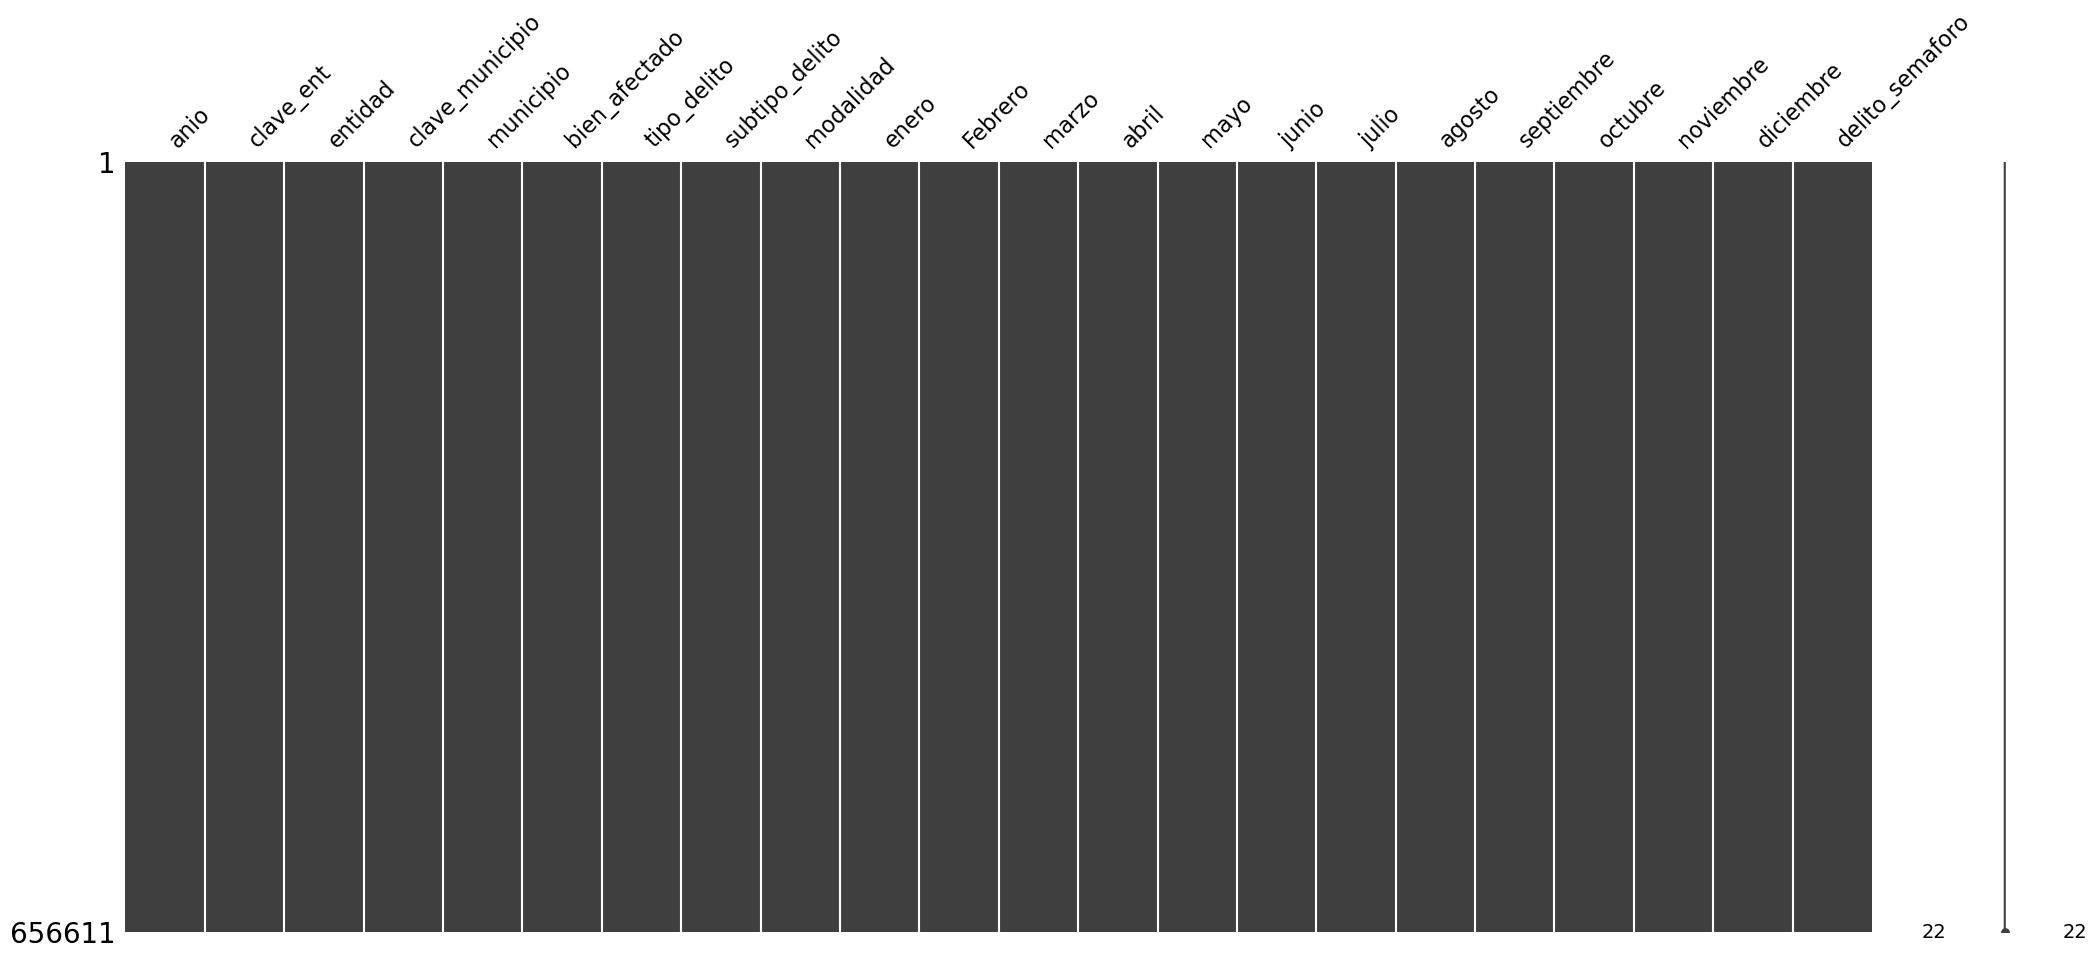

In [ ]:
"""
%matplotlib inline
import missingno as msno
"""

msno.matrix(df_delitos)

# df_delitos["delito_semaforo"].

Se observan valores faltantes, estos se refieren a aquellos delitos que no estan contemplados en el semáforo

In [ ]:
df_semaforo = df_delitos.copy()
df_semaforo = df_semaforo.dropna(axis=0)
df_semaforo = df_semaforo.reset_index()

<Axes: >

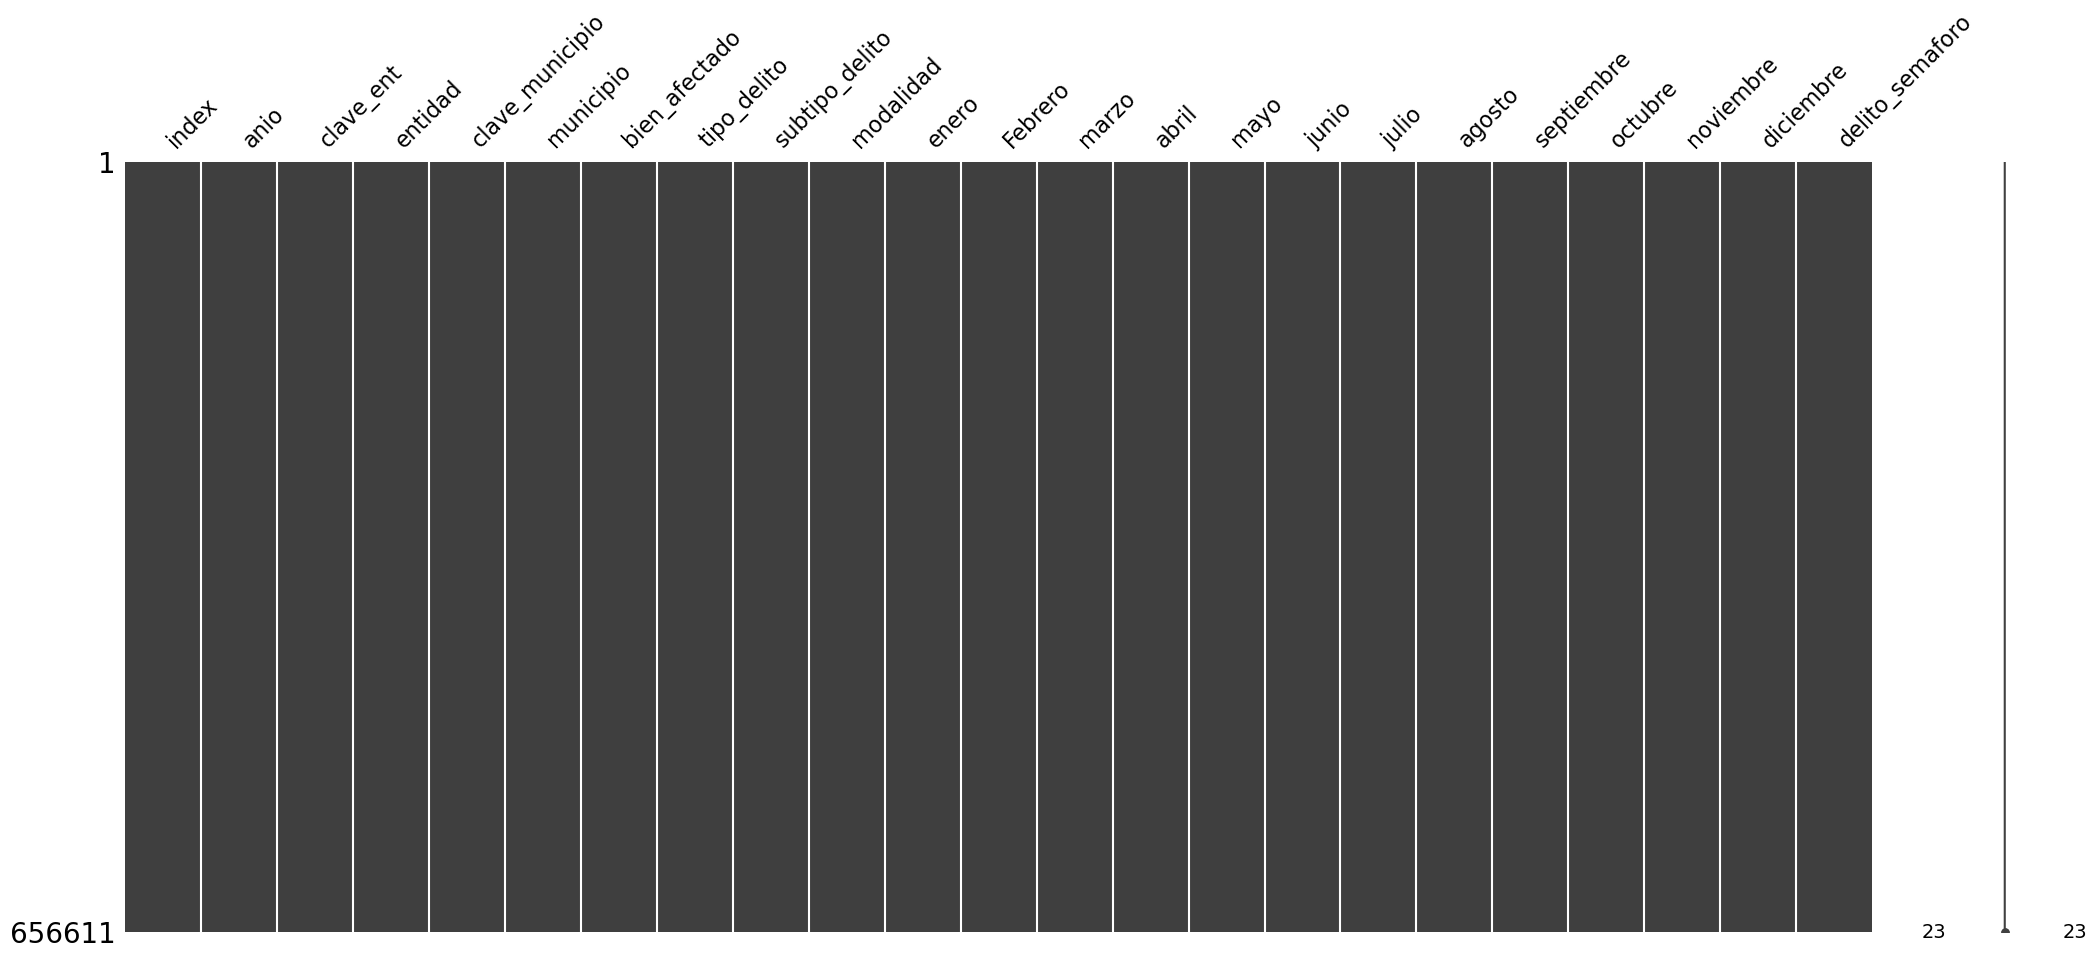

In [ ]:
"""
%matplotlib inline
"""

msno.matrix(df_semaforo)

In [ ]:
# Cambiamos el orden de las columnas
df_semaforo = df_semaforo[['anio', 'clave_ent', 'entidad', 'clave_municipio', 'municipio', 'bien_afectado', 'tipo_delito', 'subtipo_delito', 'delito_semaforo', 'modalidad', 'enero', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']]

In [ ]:
df_semaforo.head()

,anio,clave_ent,entidad,clave_municipio,municipio,bien_afectado,tipo_delito,subtipo_delito,delito_semaforo,modalidad,enero,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma de fuego,2,1,0,1,1,0,2,1,0,1
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma blanca,1,0,0,1,0,1,0,0,0,0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con otro elemento,0,1,3,2,0,1,2,0,0,0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,No especificado,1,1,0,0,0,0,0,0,0,0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Lesiones,Lesiones dolosas,Lesiones,Con arma de fuego,1,1,1,1,3,2,1,3,2,2


In [ ]:
# Sumar delitos por meses...
lista_meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']
df_semaforo[lista_meses]

,enero,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,2,1,0,1,1,0,2,1,0,1
1,1,0,0,1,0,1,0,0,0,0
2,0,1,3,2,0,1,2,0,0,0
3,1,1,0,0,0,0,0,0,0,0
4,1,1,1,1,3,2,1,3,2,2
...,...,...,...,...,...,...,...,...,...,...
656606,0,0,0,0,0,0,0,0,0,0
656607,0,0,0,0,0,0,0,0,0,0
656608,0,0,0,0,0,0,0,0,0,0
656609,0,1,0,0,0,0,0,0,0,0


In [ ]:
df_semaforo["total"] = df_semaforo[lista_meses].sum(axis = 1)

In [ ]:
df_semaforo

,anio,clave_ent,entidad,clave_municipio,municipio,bien_afectado,tipo_delito,subtipo_delito,delito_semaforo,modalidad,...,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre,total
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma de fuego,...,1,0,1,1,0,2,1,0,1,9
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con arma blanca,...,0,0,1,0,1,0,0,0,0,3
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,Con otro elemento,...,1,3,2,0,1,2,0,0,0,9
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Homicidios,No especificado,...,1,0,0,0,0,0,0,0,0,2
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Lesiones,Lesiones dolosas,Lesiones,Con arma de fuego,...,1,1,1,3,2,1,3,2,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656606,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Robo,Robo a negocio,Robo a negocio,Con violencia,...,0,0,0,0,0,0,0,0,0,0
656607,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Robo,Robo a negocio,Robo a negocio,Sin violencia,...,0,0,0,0,0,0,0,0,0,0
656608,2023,32,Zacatecas,32058,Santa María de la Paz,El patrimonio,Extorsión,Extorsión,Extorsión,Extorsión,...,0,0,0,0,0,0,0,0,0,0
656609,2023,32,Zacatecas,32058,Santa María de la Paz,La familia,Violencia familiar,Violencia familiar,Violencia familiar,Violencia familiar,...,1,0,0,0,0,0,0,0,0,1


In [ ]:
semaforo_tidy_nombre_parquet = 'delitos_semaforo.parquet'

In [ ]:
df_semaforo.to_parquet(tidy_data_path / semaforo_tidy_nombre_parquet, index = False)